In [119]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score , precision_score , recall_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve


In [121]:
df = pd.read_csv("adult.csv")

In [122]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [123]:
# Replace ? -> nan so that it can be read easily
df = df.replace('?' , np.nan)

In [124]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [125]:
# Replace missing values with the most frequent values of that column
cols_to_fix = ['workclass' , 'occupation', 'native.country']
for col in cols_to_fix:
    df[col] = df[col].fillna(df[col].mode()[0])

In [126]:
df['income'] = df['income'].str.strip()
df['income'] = df['income'].str.replace('.', '', regex = False)
df['income'] = df['income'].map({'<=50K': 0 , '>50K' : 1})

In [127]:
y = df['income']
X = df.drop('income',axis= 1)

In [128]:
#Stores all categorical columns
X.select_dtypes(include=['object', 'category']).columns.tolist()

# One-hot encoding of all categorical cols
X =pd.get_dummies(X , drop_first=True)

In [129]:
# Train test split
X_train , X_test , y_train , y_test = train_test_split(X, y , test_size = 0.2 , random_state = 42)

# Decision Tree Classifier

In [130]:
# Training the model 
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [131]:
y_prob_dt = dt.predict_proba(X_test)[:, 1]

prec_dt = precision_score(y_test, y_pred)
rec_dt  = recall_score(y_test, y_pred)
auc_dt  = roc_auc_score(y_test, y_prob_dt)


# Random Forest Classifier

In [132]:
from sklearn.ensemble import RandomForestClassifier

In [133]:
rf = RandomForestClassifier(n_estimators=100 , max_depth= 10, random_state =42)
rf.fit(X_train , y_train)
y_pred_rf = rf.predict(X_test)

In [134]:
acc_rf = accuracy_score(y_test , y_pred_rf)
print("Accuracy of Random Forest: ", acc_rf)

Accuracy of Random Forest:  0.8547520343927529


In [135]:
y_prob_rf = rf.predict_proba(X_test)[:, 1]

prec_rf = precision_score(y_test, y_pred_rf)
rec_rf  = recall_score(y_test, y_pred_rf)
auc_rf  = roc_auc_score(y_test, y_prob_rf)


# LGBM Classifier

In [136]:
from lightgbm import LGBMClassifier

#  Initializing  LightGBM
lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31, 
    random_state=42
)

# Train the model

lgbm_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_lgbm = lgbm_model.predict(X_test)
acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("--- LightGBM Performance ---")
print(f"Accuracy:", acc_lgbm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgbm))

[LightGBM] [Info] Number of positive: 6304, number of negative: 19744
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242015 -> initscore=-1.141665
[LightGBM] [Info] Start training from score -1.141665
--- LightGBM Performance ---
Accuracy: 0.872255489021956

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4976
           1       0.78      0.63      0.70      1537

    accuracy                           0.87      6513
   macro avg       0.84      0.79      0.81      6513
weighted avg       0.87      0.87      0.87      6513



In [137]:
y_prob_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

prec_lgbm = precision_score(y_test, y_pred_lgbm)
rec_lgbm  = recall_score(y_test, y_pred_lgbm)
auc_lgbm  = roc_auc_score(y_test, y_prob_lgbm)


# Hypertuned Random Forest

In [138]:
# Task 4
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(random_state=42)

param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_random = RandomizedSearchCV(
    estimator=rf1,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train, y_train)

print("Best Parameters:", rf_random.best_params_)
print("Best CV Score:", rf_random.best_score_)


Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}
Best CV Score: 0.8628685971291024


In [139]:
y_prob_tuned_rf = best_rf.predict_proba(X_test)[:, 1]

prec_tuned_rf = precision_score(y_test, y_pred_tuned_rf)
rec_tuned_rf  = recall_score(y_test, y_pred_tuned_rf)
auc_tuned_rf  = roc_auc_score(y_test, y_prob_tuned_rf)


In [140]:
#  Random Forest Feature Importance
import pandas as pd
import matplotlib.pyplot as plt

importances = best_rf.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feature_importance_df.head(10)


,Feature,Importance
29,marital.status_Married-civ-spouse,0.146355
3,capital.gain,0.134749
0,age,0.105128
2,education.num,0.102550
5,hours.per.week,0.063083
1,fnlwgt,0.060862
31,marital.status_Never-married,0.049122
4,capital.loss,0.037803
36,occupation_Exec-managerial,0.027941
47,relationship_Not-in-family,0.025289


In [141]:
final_metrics = pd.DataFrame({
    "Model": [
        "Decision Tree",
        "Random Forest",
        "LightGBM",
        "Tuned Random Forest"
    ],
    "Accuracy": [
        acc_dt,
        acc_rf,
        acc_lgbm,
        acc_tuned_rf
    ],
    "Precision": [
        prec_dt,
        prec_rf,
        prec_lgbm,
        prec_tuned_rf
    ],
    "Recall": [
        rec_dt,
        rec_rf,
        rec_lgbm,
        rec_tuned_rf
    ],
    "ROC_AUC": [
        auc_dt,
        auc_rf,
        auc_lgbm,
        auc_tuned_rf
    ]
})

final_metrics
 

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Decision Tree,0.815600,0.606494,0.607677,0.742946
1,Random Forest,0.854752,0.787731,0.526350,0.907664
2,LightGBM,0.872255,0.783133,0.634353,0.927278
3,Tuned Random Forest,0.863811,0.771739,0.600520,0.914747


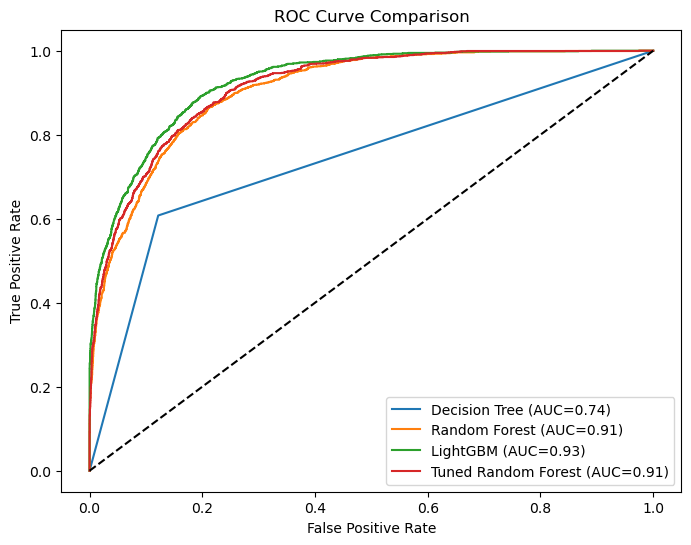

In [142]:
plt.figure(figsize=(8,6))

for model_name, y_prob in [
    ("Decision Tree", y_prob_dt),
    ("Random Forest", y_prob_rf),
    ("LightGBM", y_prob_lgbm),
    ("Tuned Random Forest", y_prob_tuned_rf)
]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.2f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


# Decision Tree Classifier
The model is predicting positives too easily which is increasing recall but lowering precision. Low ROC AUC shows it cannot clearly seperate higher & lower income people.

# Random Forest Classifier
Accuracy & Precision are higher than Deicision Tree showing that it is making more reliable predictions. Recall is slightly lower meaning the model is careful while predicting higher income.

# Light GBM 
RUC AUC are high which means that it ranks high income and low income people clearly. Metrics looks balanced which means it does not blindly predict positives and negatives. This happens becuase LightGBM learns from previous mistakes through boosting technique.

# Hyperparameter tuned RandomForest Classifier
Metrics are better than previous Random Forest Classifier. Also, the precision which means the model is making fewer false positives predictions. This is happening because of tuning the parameter like tree depth.